In [21]:
import glob
import os
from shutil import copyfile

import scipy.io as sio

import cv2
import numpy as np
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage.morphology import distance_transform_cdt, distance_transform_edt

from misc.patch_extractor import PatchExtractor
from misc.utils import rm_n_mkdir

from config import Config


def bounding_box(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    # due to python indexing, need to add 1 to max
    # else accessing will be 1px in the box, not out 
    rmax += 1
    cmax += 1
    return [rmin, rmax, cmin, cmax]

def draw_contours(mask, ann_inst, line_thickness=1):
    overlay = np.copy((mask).astype(np.uint8))

    label_map = ann_inst
    instances_list = list(np.unique(label_map))  # get list of instances
    instances_list.remove(0)  # remove background
    contours = []
    for inst_id in instances_list:
        instance_map = np.array(
            ann_inst == inst_id, np.uint8)  # get single object
        y1, y2, x1, x2 = bounding_box(instance_map)
        y1 = y1 - 2 if y1 - 2 >= 0 else y1
        x1 = x1 - 2 if x1 - 2 >= 0 else x1
        x2 = x2 + 2 if x2 + 2 <= ann_inst.shape[1] - 1 else x2
        y2 = y2 + 2 if y2 + 2 <= ann_inst.shape[0] - 1 else y2
        inst_map_crop = instance_map[y1:y2, x1:x2]
        contours_crop = cv2.findContours(
            inst_map_crop, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        index_correction = np.asarray([[[[x1, y1]]]])
        for i in range(len(contours_crop[0])):
            contours.append(
                list(np.asarray(contours_crop[0][i].astype('int32')) + index_correction))
    contours = list(itertools.chain(*contours))
    cv2.drawContours(overlay, np.asarray(contours), -1, 1, line_thickness)
    return overlay

In [55]:
img_ext = '.png'
img_dir = '/home1/gzy/NucleiSegmentation/High_CCRCC/Test/Images/'
ann_dir = '/home1/gzy/NucleiSegmentation/High_CCRCC/Test/Labels/' 
####

file_list = glob.glob('%s/*%s' % (img_dir, img_ext))
file_list.sort()

In [56]:
for filename in tqdm(file_list):
    filename = os.path.basename(filename)
    basename = filename.split('.')[0]
    #print(filename)

    img = cv2.imread(img_dir + basename + img_ext)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    labels = sio.loadmat(ann_dir + basename + '.mat')
    ann_inst = labels['instance_map'] 
    #     labels['positive_map'] = labels['positive_map'][...,0] 
    #     labels['negative_map'] = labels['negative_map'][...,0] 
    inst_list = list(np.unique(ann_inst))[1:]
    dist_map = np.zeros_like(ann_inst, dtype='float')
    for inst_id in inst_list:
        mask = ann_inst.copy()
        mask[mask!=inst_id] = 0
        mask[mask!=0] = 1
        fg_dist = distance_transform_edt(mask)

        v_max = fg_dist[ann_inst == inst_id].max()
        v_min = fg_dist[ann_inst == inst_id].min()
        dist_map[ann_inst == inst_id] = 0.9*(fg_dist[ann_inst == inst_id]-v_min)/(v_max-v_min) + 0.1
    labels['marker_map'] = dist_map
    
#     mask[mask==1] = 2
#     mask = draw_contours(mask, ann_inst)
#     mask[mask==2] = 0

#     fg_dist = distance_transform_edt(-(mask-1))
#     # bg_dist = distance_transform_edt(-(mask-1))
#     # dist_map = fg_dist+bg_dist
#     dist_map = -fg_dist + 10
#     dist_map[dist_map<0] = 0
#     dist_map = dist_map/dist_map.max()
#     labels['dist_map'] = dist_map
    sio.savemat(ann_dir + basename + '.mat', labels)

100%|██████████| 200/200 [15:55<00:00,  4.78s/it]


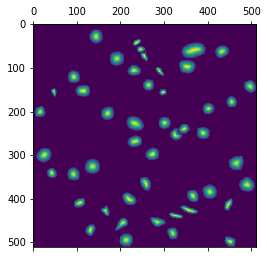

In [53]:
filename = file_list[5]
filename = os.path.basename(filename)
basename = filename.split('.')[0]
labels = sio.loadmat(ann_dir + basename + '.mat')
plt.matshow(labels['marker_map'])

In [54]:
np.unique(labels['marker_map'])

array([0.        , 0.1       , 0.12264253, ..., 1.        , 1.        ,
       1.        ])